# Python Analysis Tool for Epitaxial thin film X-ray diffraction data (PATEX)

## Notebook by Zach Drinkwater
### Updated February 2024

The purpose of this notebook is to provide an example of how patex.py can be used as a data analysis pipeline for thin film XRD data. This code fits curves to the peaks in the data and then uses the fitted curves to estimate peak location, width, height. Peaks locations are used to find the out of plane lattice parameter using Bragg's law:
$$ n \lambda =2d\sin \theta $$


The equations governing williamson-hall are:


$$ \beta = 0.5 H (\pi / log_{e}2)^{1/2}$$

$$ \beta \cos \theta = K \frac{\lambda}{D} + 4 \epsilon \sin \theta $$

* Ql = sin(2 theta/2)
* Beta measured is substrate beta

Instructions:
1. Change the variable filename to the filename of the .txt or .dat file produced by XRD and set lam to the X-ray wavelength used in the experiment.
2. Indicate the type of curve you wish to fit (Gaussian, Lorentzian, or Voigt) by setting the variable curve_type to either "g", "l" or "v".
3. Indicate the number of expected peaks (substrate_peaks for substrate, film_peaks for film)
4. If extracting film peaks, indicate whether it is expected that the peaks will be to the right or to the left of the substrate peaks. If unknown, try both.
5. If getting undesirable peaks, try increasing sigma (Gaussian smoothing), or adjusting the peak finding parameters.

NOTES:
* Data was collected at 0.1 degree per reading so 1 idx = 0.01 degree
* Currently using FWHM/2 for the error in the peak locations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from patex import XRDPeakData # This module was created for this project.

In [2]:
### SELECT THESE PARAMETERS ###
filename = 'RH014JA_2theta-om_15-115deg_1-1-1_2-Theta_Omega.txt'
lam = 1.5406e-10 # X-ray wavelength
#film = True # Set to True for film peaks or False for substrate peaks
film_left = True # Set to True if film peaks are expected to be left of the substrate peaks, and False if vice versa

substrate_peaks = 4 # The number of expected
film_peaks = 3

curve_type = 'g' # 'g' for Gaussian, 'l' for Cauhcy-Lorentz, 'v' for voigt
plot_raw_data = True # Plots the raw data
plot_fit = True # Plots the fitted curves for each peak

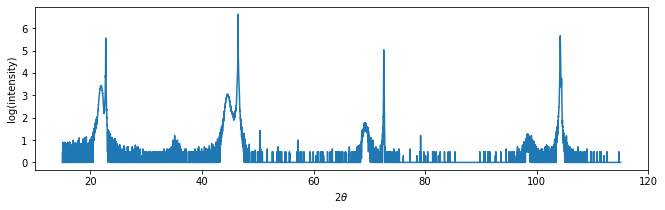

In [3]:

### ADJUST IF FITTING IS PRODUCING UNDESIRABLE RESULTS ###
min_peak_intensity = 1e1 # Minimum peak intensity (COMMONLY NEEDS ADJUSTING)
max_peak_intensity = 1e10 # Maximum peak intensity
idx_halfrange = 40 # Index range to fit over (plus/minus) where 100 = 1 degree
distance = 50 # Minimum distance between peaks (idx)
prominence = 10 # Minimum prominence of peaks
width = [1, 100] # Width range of peaks
peak_params = [min_peak_intensity, max_peak_intensity, idx_halfrange, distance, prominence, width]
############################################

data1 = XRDPeakData(filename, lam, skiprows=3)

if plot_raw_data == True:
    raw = data1.plot_raw_peak_data()




Substrate peaks found at [ 22.75  46.47  72.57 104.21]


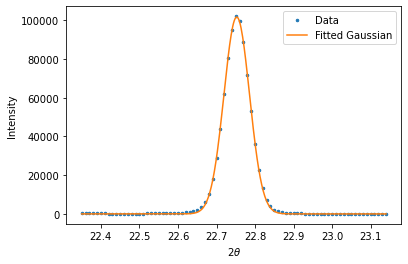

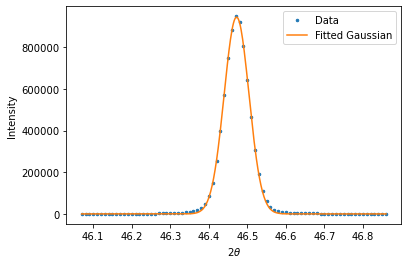

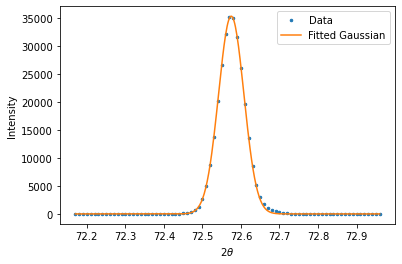

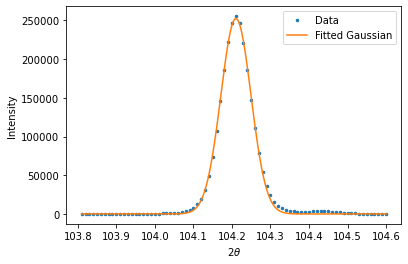

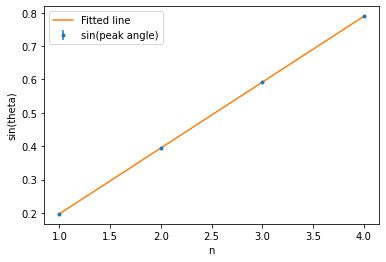

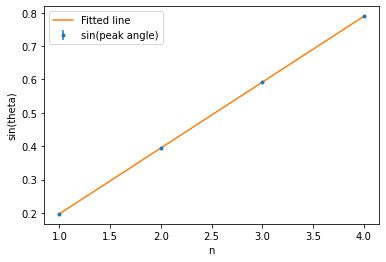

Substrate peak at 2theta = 22.75 ± 0.04 degrees has intensity 1.016e+05 ± 4e+02 and FWHM 0.07799 ± 0.00023 degrees
Substrate peak at 2theta = 46.47 ± 0.04 degrees has intensity 9.441e+05 ± 3.7e+03 and FWHM 0.07575 ± 0.00023 degrees
Substrate peak at 2theta = 72.57 ± 0.04 degrees has intensity 3.535e+04 ± 1.2e+02 and FWHM 0.07717 ± 0.00020 degrees
Substrate peak at 2theta = 104.21 ± 0.05 degrees has intensity 2.524e+05 ± 1.7e+03 and FWHM 0.09201 ± 0.00047 degrees
The substrate lattice parameter (d) is 3.904 ± 0.003 A


Film peaks found at [21.91 44.61 69.21]


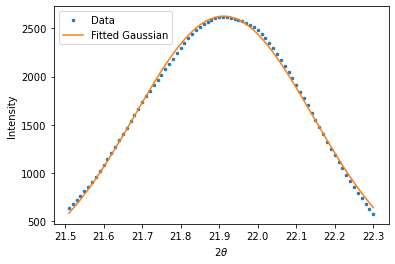

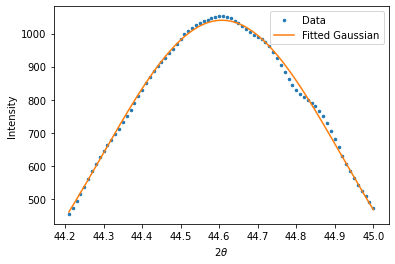

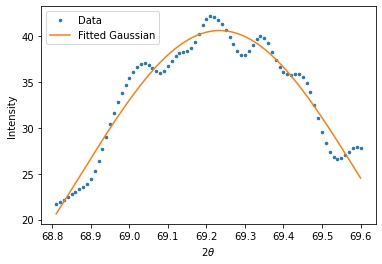

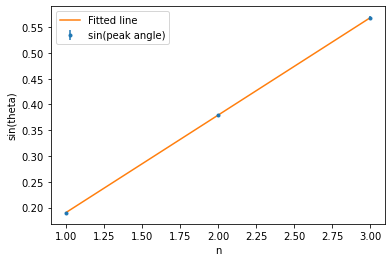

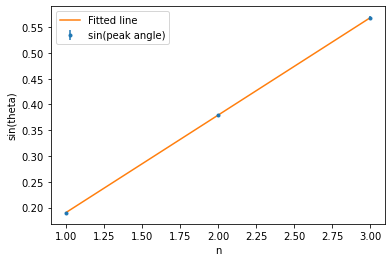

Film peak at 2theta = 21.91 ± 0.27 degrees has intensity 2626 ± 11 and FWHM 0.54379 ± 0.00183 degrees
Film peak at 2theta = 44.61 ± 0.37 degrees has intensity 1040 ± 4.7 and FWHM 0.73053 ± 0.00262 degrees
Film peak at 2theta = 69.23 ± 0.43 degrees has intensity 40.57 ± 0.79 and FWHM 0.85685 ± 0.01316 degrees
The film lattice parameter (d) is 4.074 ± 0.041 A


In [4]:
sigma = 3 # Adjust as necessary
data1.filter_data(sigma) # Filters data using Gaussian smoothing
substrate_data = data1.fit_all_peaks(peak_params, curve=curve_type, film_left=film_left, film=False, num_peaks=substrate_peaks, plot=plot_fit)
d, d_err = data1.get_lattice_parameter(substrate_data, plot=True)

try:
    for i in range(len(substrate_data[0, :])):
        if substrate_data[0, i] > 0 and substrate_data[0, i] < 180 and substrate_data[1, i] < 1e10 and substrate_data[3, i] < 1 and substrate_data[2, i] < 2:
            print(f'Substrate peak at 2theta = {substrate_data[0, i]:.2f} ± {substrate_data[3, i]:.2f} degrees has intensity {substrate_data[1, i]:.4g} ± {substrate_data[4, i]:.2g}'
                  + f' and FWHM {substrate_data[2, i]:.5f} ± {substrate_data[5, i]:.5f} degrees')

    print(f'The substrate lattice parameter (d) is {d*1e10:.3f} ± {d_err*1e10:.3f} A')
except TypeError:
    print('Error')

print("\n")

film_data = data1.fit_all_peaks(peak_params, curve=curve_type, film_left=film_left, film=True, num_peaks=film_peaks, plot=plot_fit)
d, d_err = data1.get_lattice_parameter(film_data, plot=True)
try:
    for i in range(len(film_data[0, :])):
        if film_data[0, i] > 0 and film_data[0, i] < 180 and film_data[1, i] < 1e10 and film_data[3, i] < 1 and film_data[2, i] < 2:
            print(f'Film peak at 2theta = {film_data[0, i]:.2f} ± {film_data[3, i]:.2f} degrees has intensity {film_data[1, i]:.4g} ± {film_data[4, i]:.2g}'
                  + f' and FWHM {film_data[2, i]:.5f} ± {film_data[5, i]:.5f} degrees')

    print(f'The film lattice parameter (d) is {d*1e10:.3f} ± {d_err*1e10:.3f} A')
except TypeError:
    print('Error')

In [5]:
# Williamson-Hall STILL WORK IN PROGRESS
# num_peaks = 3
# epsilon, intercept = data1.williamson_hall(peak_params, film_left, num_peaks, fit='linear')
# print(f"The strain coefficient is {epsilon:.2g} with intercept {intercept:.2g}")